Лабораторна робота №2

з курсу 'Основи технологій машинного навчання'

Класифікація видів об’єктів.

Предментна область: М'ячі.

Види: 1)футбольні; 2)баскетбольні; 3)тенісні.

Виконав: студент групи ТІ-72

Бортнічук Нікіта Олександрович

Виконано у сервісі gradient

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

voila 0.2.4 requires nbconvert<7,>=6.0.0, but you'll have nbconvert 5.6.1 which is incompatible.


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [4]:
def search_images_bing(key, term, max_images: int = 150, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json() 
   
    # returns an L object to be identical to the original function.
    return L(search_results['value'])

search_images_bing

<function __main__.search_images_bing(key, term, max_images: int = 150, **kwargs)>

In [5]:
results = search_images_bing('50e7821fe35c4bc1a5307c5533bf738d', 'soccer ball')
ims = results.attrgot('contentUrl') # in new bing use camelCase
len(ims)

150

In [6]:
results

(#150) [{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=soccer+ball&id=1F1E0E199E838821BB0C8D0980FD7A285C0F7769&simid=608004104959494586', 'name': 'Soccer ball | SIBC', 'thumbnailUrl': 'https://tse3.mm.bing.net/th?id=OIP.uAAW2SAl-ISFwKoMdOPMxQHaE8&pid=Api', 'datePublished': '2020-05-14T03:23:00.0000000Z', 'isFamilyFriendly': True, 'contentUrl': 'http://www.sibconline.com.sb/wp-content/uploads/2015/01/Soccer-ball.jpg', 'hostPageUrl': 'http://www.sibconline.com.sb/haroro-2015-tourney-ends-with-prize-giving-ceremony/soccer-ball-2/', 'contentSize': '2098294 B', 'encodingFormat': 'jpeg', 'hostPageDisplayUrl': 'www.sibconline.com.sb/haroro-2015-tourney-ends-with-prize-giving-ceremony/soccer-ball-2', 'width': 5370, 'height': 3580, 'hostPageDiscoveredDate': '2015-02-16T00:00:00.0000000Z', 'thumbnail': {'width': 474, 'height': 316}, 'imageInsightsToken': 'ccid_uAAW2SAl*cp_3708BDAC059FD775BADA51648AD26D6E*mid_1F1E0E199E838821BB0C8D0980FD7A285C0F7769*simid_6080041

In [7]:
ims[0]

'http://www.sibconline.com.sb/wp-content/uploads/2015/01/Soccer-ball.jpg'

In [8]:
dest = 'images/soccer.jpg'
download_url(ims[0], dest)

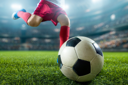

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
ball_types = 'soccer','basketball','tennis'
path = Path('balls')

In [11]:
if not path.exists():
    path.mkdir()
    for o in ball_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing('50e7821fe35c4bc1a5307c5533bf738d', f'{o} ball')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [12]:
fns = get_image_files(path)
fns

(#436) [Path('balls/basketball/00000000.jpg'),Path('balls/basketball/00000001.jpg'),Path('balls/basketball/00000002.jpg'),Path('balls/basketball/00000003.jpg'),Path('balls/basketball/00000004.jpg'),Path('balls/basketball/00000005.jpg'),Path('balls/basketball/00000006.jpg'),Path('balls/basketball/00000007.png'),Path('balls/basketball/00000008.jpg'),Path('balls/basketball/00000009.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#0) []

In [14]:
failed.map(Path.unlink);

In [15]:
balls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:

dls = balls.dataloaders(path)

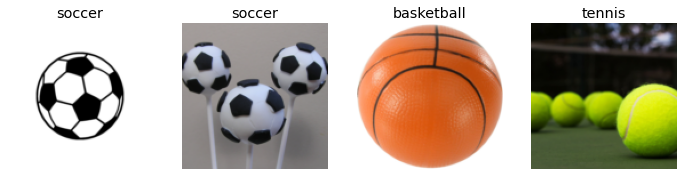

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

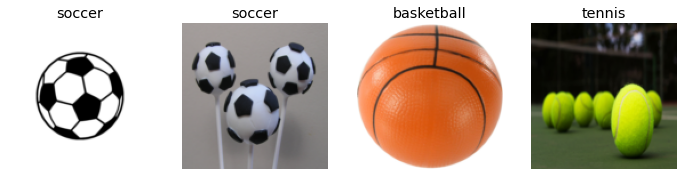

In [18]:
balls = balls.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = balls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

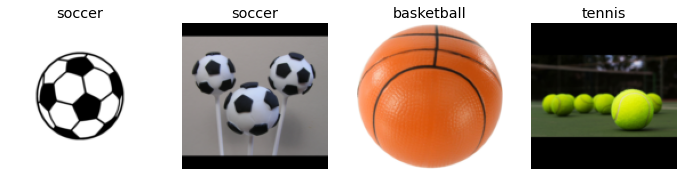

In [19]:
balls = balls.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = balls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

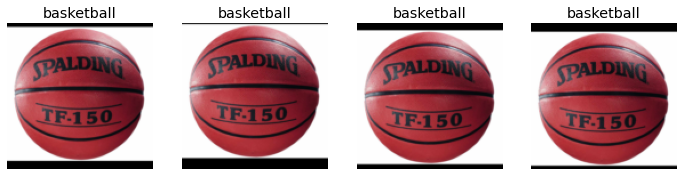

In [20]:
dls = balls.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

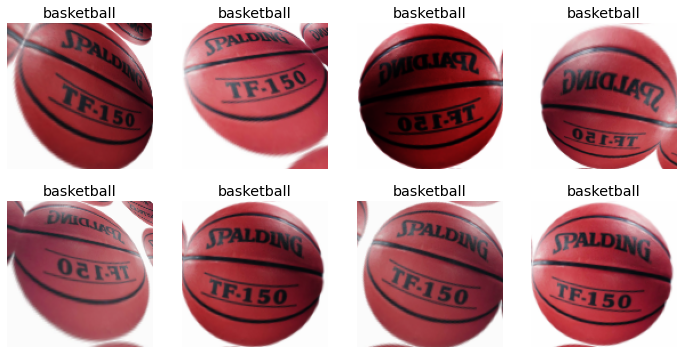

In [21]:
#data augmentation
balls = balls.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = balls.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [22]:
# Training Your Model, and Using It to Clean Your Data
balls = balls.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = balls.dataloaders(path)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.566143,0.325300,0.183908,00:10


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.303054,0.162769,0.080460,00:12
1,0.195538,0.078741,0.022989,00:11
2,0.156101,0.063704,0.034483,00:12
3,0.121471,0.064120,0.022989,00:11
4,0.102935,0.051065,0.011494,00:11
5,0.083263,0.058786,0.011494,00:11
6,0.068324,0.063740,0.011494,00:11
7,0.059697,0.063396,0.011494,00:13
8,0.050768,0.063593,0.011494,00:11
9,0.046536,0.064639,0.011494,00:10


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: U

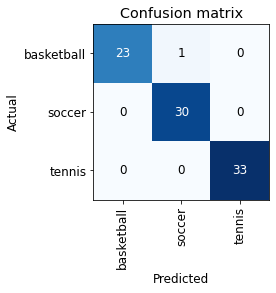

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

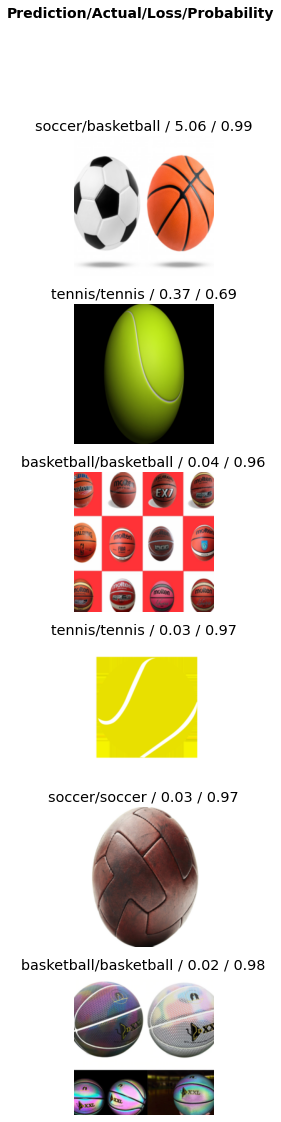

In [25]:
interp.plot_top_losses(6, nrows=6)

In [26]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [27]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [28]:
learn.export()

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [30]:
learn_inf = load_learner(path/'export.pkl')

In [31]:
learn_inf.predict('images/soccer.jpg')

('soccer', TensorImage(1), TensorImage([7.4518e-05, 9.9992e-01, 9.4899e-06]))

In [32]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [33]:
btn_upload = SimpleNamespace(data = ['images/soccer.jpg'])

In [34]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred, pred_idx, probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your ball!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix